# **Introduction**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Objectives:</b> train and apply knowledge about Convolutional Neural Network to create and train a model to predict the weather from an image. I hope you like the notebook!</div>

<img src="https://images.pexels.com/photos/186980/pexels-photo-186980.jpeg?auto=compress&cs=tinysrgb&w=1600" style="width:550px;height:300px; border-radius:30px"></img>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Technologies Used:</b></div>
<ul style="font-family:'Nunito', sans-serif; font-size:18px">
    <li><b>Pytorch</b> for load the data, build the model architeture, train it and avaliate it with new images.</li>
    <li><b>OpenCV</b> for image reading and processing.</li>
    <li><b>Pandas</b> and <b>NumPy</b> for data manipulation and organization.</li>
    <li><b>Scikit-Learn</b> for metric, classification report and train_test_split.</li>
    <li><b>Matplotlib</b> and <b>Seaborn</b> for Data and Images Visualization.</li>
    <li><b>Requests</b> for web images predict.</li>
</ul>

# **Imports**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

In [1]:
# - Data Manipulation - #
import numpy as np 
import pandas as pd

# - Data Visualization and Image Transformation - #
import cv2
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# - Datasets manipulation and Neural Network - #
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# - Data Preparation and Model Validation - # 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score 

# - Utils - #
import time
import gc
import requests
import os

In [2]:
os.mkdir("./fonts")
np.random.seed(404)

In [3]:
# - Get the Font - #
url = "https://github.com/lucas142129silva/Movies-Exploratory-Data-Analysis/blob/main/fonts/FRAMD_M.ttf?raw=true"
r = requests.get(url)
with open("./fonts/framd_m.ttf", "wb") as f:
    f.write(r.content)
    
font = fm.FontProperties(fname="./fonts/framd_m.ttf")

# **Reading the Data**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

In [4]:
data = list()

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        label = dirname.split("/")[-1]
        image = os.path.join(dirname, filename)
        data.append((label, image))

In [5]:
df = pd.DataFrame(data, columns=["label", "image"])
df.head()

label                                              image
0  hail  /kaggle/input/weather-dataset/dataset/hail/010...
1  hail  /kaggle/input/weather-dataset/dataset/hail/037...
2  hail  /kaggle/input/weather-dataset/dataset/hail/028...
3  hail  /kaggle/input/weather-dataset/dataset/hail/007...
4  hail  /kaggle/input/weather-dataset/dataset/hail/007...

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Histogram for labels:</b> plot how many appearences are there for each label, and a line containing the mean appearences value for all labels.</div>

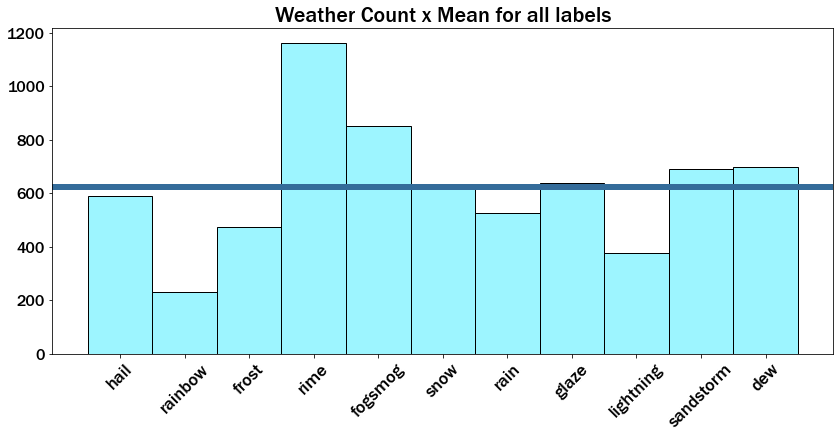

In [6]:
ax = sns.histplot(data=df, x="label", color="#7df2ff")
ax.figure.set_size_inches(14, 6)
plt.axhline(y=df.groupby("label").count().mean().mean(), lw=6, color="#346c9a")
plt.xticks(rotation=45, font=font, fontsize=18)
plt.yticks(font=font, fontsize=16)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Weather Count x Mean for all labels", font=font, fontsize=22)

plt.show()

In [7]:
unique_labels = df['label'].unique()
unique_labels

array(['hail', 'rainbow', 'frost', 'rime', 'fogsmog', 'snow', 'rain',
       'glaze', 'lightning', 'sandstorm', 'dew'], dtype=object)

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Example of each label:</b></div>

In [8]:
examples = pd.DataFrame([])
for label in unique_labels:
    examples = pd.concat([examples, df.query(f"label == '{label}'").sample(1)])

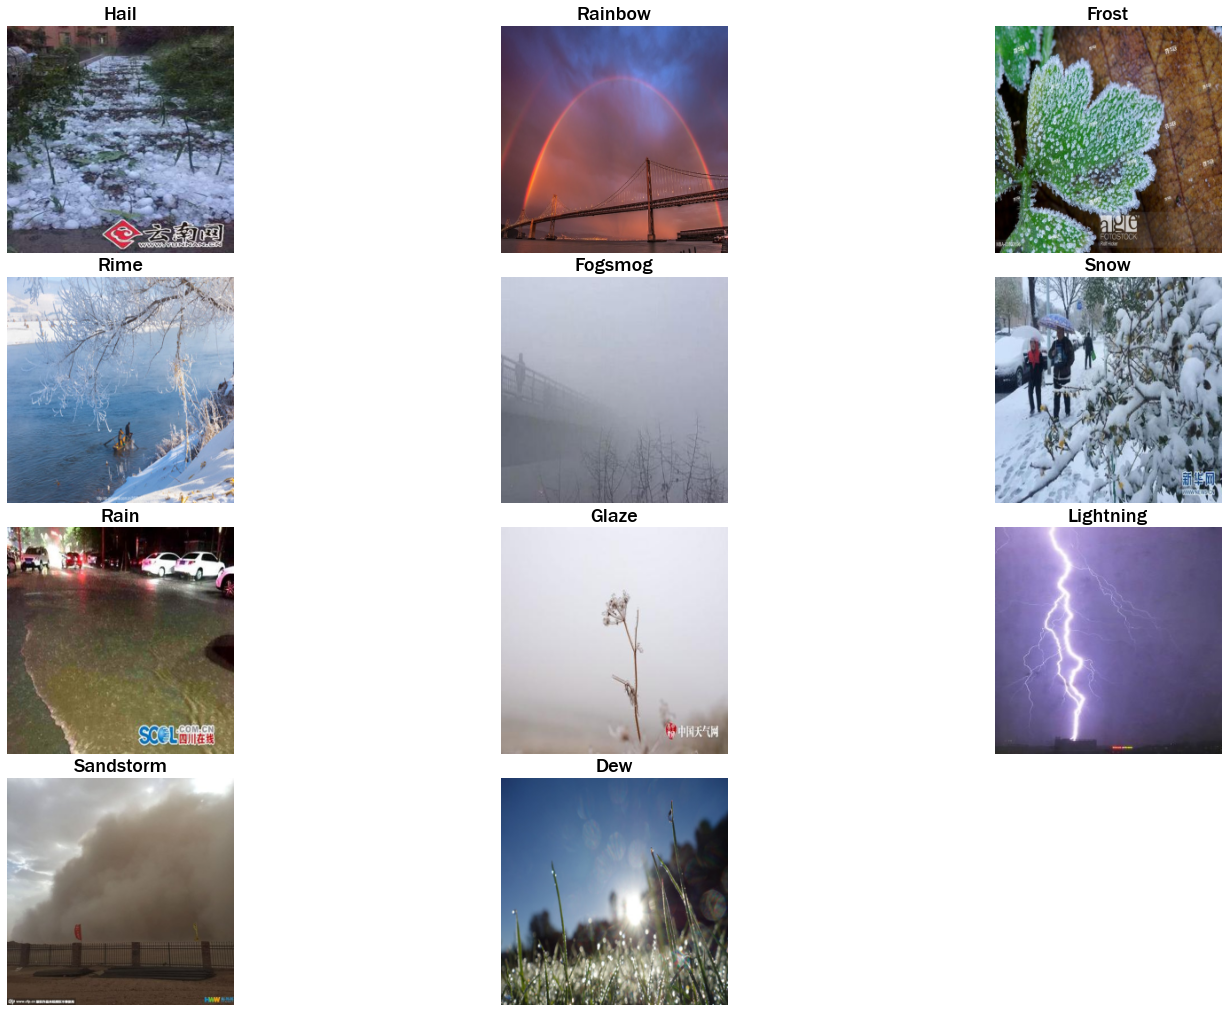

In [9]:
fig = plt.figure(figsize=(22, 14))
for index, row in examples.reset_index().iterrows():
    ax = plt.subplot(4, 3, index + 1)
    image = cv2.imread(row["image"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    plt.imshow(image)
    ax.set_title(row["label"].title(), font=font, fontsize=20)
    ax.axis("off")

fig.tight_layout(pad=0.5)
plt.show()

# **Transforming the Data**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Transform paths into arrays:</b> Pytorch can handle float32 NumPy arrays, so it reads using the OpenCV library and transform the image into a NumPy array resized to 256 x 256.</div>

In [10]:
def process_image(img):
    try:
        pic = cv2.imread(img)
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)
        pic = cv2.resize(pic, (256, 256), interpolation=cv2.INTER_AREA)
        pic = np.array(pic, dtype=np.float32)
        return pic
    except:
        return np.zeros(shape=(256, 256, 3), dtype=np.float32)

In [11]:
list_of_paths = df["image"].to_numpy()

images = [process_image(path) for path in list_of_paths]

images = np.array(images, dtype=np.float32)

images.shape

(6862, 256, 256, 3)

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Vectorizing the labels:</b> Machine Learning models use numeric values, so it transform each array into its unique value, numbers in the lengh of the total of labels.</div>

In [12]:
unique_labels = list(unique_labels) # Use for indexing the labels - ("hail", 0), ("rainbow", 1)

labels = df["label"].to_numpy()

# Using the unique labels list
def convert_categorical_to_number(label):
    return unique_labels.index(label)

func = np.vectorize(convert_categorical_to_number)
labels = func(labels)
labels

array([ 0,  0,  0, ..., 10, 10, 10])

# **Preparing the Data**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Split into train and test:</b> fundamental part of machine learning, the split chosen was 80% for training and 20% for validation.</div>

In [13]:
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2)

In [14]:
print("Sizes:\n")
print("# - Train", images_train.shape, sep="\n")
print(labels_train.shape)
print("# - Test", images_test.shape, sep="\n")
print(labels_test.shape)

Sizes:

# - Train
(5489, 256, 256, 3)
(5489,)
# - Test
(1373, 256, 256, 3)
(1373,)


<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Transform the data to Torch Tensor:</b> the torch tensor has its size like (Batch x Color Channels x Height x Width), so it needs to permute the dimensions to get it right for images that have its size from readind like (Batch x Height x Width x Color Channels).</div>

In [15]:
images_train = torch.from_numpy(images_train).permute(0, 3, 1, 2)
images_test = torch.from_numpy(images_test).permute(0, 3, 1, 2)
labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

In [16]:
print("Right sizes for torch:\n")
print("# - Train", images_train.shape, sep="\n")
print(labels_train.shape)
print("# - Test", images_test.shape, sep="\n")
print(labels_test.shape)

Right sizes for torch:

# - Train
torch.Size([5489, 3, 256, 256])
torch.Size([5489])
# - Test
torch.Size([1373, 3, 256, 256])
torch.Size([1373])


In [17]:
# Free Memory
del images
_ = gc.collect()

# **Building the Dataloader**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Defining the Hyperparams:</b> define the hyperparams for net, batch_size, learning rate and the device (using GPU), all of them grouped into a dictionary for easy access and modification.</div>

In [18]:
# Hyperparams Configuration.
args = {
    'epoch_num': 150,     
    'lr': 1e-3,           # Learning Rate
    'weight_decay': 1e-3, # L2 Penalty
    'batch_size': 20
}

In [19]:
if torch.cuda.is_available():
    args["device"] = torch.device("cuda")
else:
    args["device"] = torch.device("cpu")
    
print(args["device"])

cuda


<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Building the Dataset and Dataloader:</b> DataLoader helps handling the batches for training, and to create the dataloader, first it needs to get from a Dataset.</div>

In [20]:
class ImagesLabelsDataset(Dataset):
    def __init__(self, images_array, labels_array, scaler_feat=None, scaler_label=None):

        self.labels = labels_array
        self.images = images_array
        
    def __getitem__(self, idx):

        sample = self.images[idx]
        label  = self.labels[idx]

        return sample, label

    def __len__(self):
        return len(self.labels)

In [21]:
# - Dataset first - #
train_set = ImagesLabelsDataset(images_train, labels_train)
test_set = ImagesLabelsDataset(images_test, labels_test)

# - Dataloader - #
train_loader = DataLoader(train_set,
                          args['batch_size'],
                          shuffle=True)
test_loader = DataLoader(test_set,
                         args['batch_size'],
                         shuffle=False)

In [22]:
for batch in train_loader:
    img, lbl = batch
    print('## Batch shape ##')
    print(img.size(), lbl.size())
    break

## Batch shape ##
torch.Size([20, 3, 256, 256]) torch.Size([20])


# **Model Architecture**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Architecture:</b> convolutional blocks with a linear block to classification.</div>

In [23]:
class ConvolutionalModel(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.net = nn.Sequential(
            ## ConvBlock 1
            nn.Conv2d(3, 6, kernel_size=4, stride=1, padding=0),        
            # Input: (b, 3, 256, 256) || Output: (b, 6, 250, 250)
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=5, stride=5, padding=0),           
            # Input: (b, 6, 250, 250) || Output: (b, 6, 50, 50)

            ## ConvBlock 2
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),       
            # Input: (b, 6, 50, 50) || Output: (b, 16, 46, 46)
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0),           
            # Input: (b, 16, 46, 46) || Output: (b, 16, 23, 23)

            ## ConvBlock 3
            nn.Conv2d(16, 32, kernel_size=8, stride=1, padding=0),     
            # Input: (b, 16, 23, 23) || Output: (b, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=4, stride=4, padding=0),           
            # Input: (b, 32, 16, 16) || Output: (b, 32, 4, 4)

            ## ConvBlock 4
            nn.Conv2d(32, 120, kernel_size=4, stride=1, padding=0),     
            # Input: (b, 32, 4, 4) || Output: (b, 120, 1, 1)
            nn.BatchNorm2d(120),
            nn.Tanh(),
            nn.Flatten(),  # flat to a vector                
            # Input: (b, 120, 1, 1) || Output: (b, 120*1*1) = (b, 120)
            
            nn.Dropout(p=0.32), # Avoid Overfitting
            ## DenseBlock
            nn.Linear(120, 84),                                         
            # Input: (b, 120) || Output: (b, 84)
            nn.Tanh(),
            nn.Linear(84, output_size)                                
            # Input: (b, 84) || Output: (b, 10)
        )
        
    def forward(self, X):
        output = self.net(X)
        return output

In [24]:
net = ConvolutionalModel(len(unique_labels)).to(args["device"])

# **Training**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Training Parameters:</b> the loss function chosen was Cross Entropy Loss while the optimizer was Adam, with the hyperparams defined by the arguments dictionary.</div>

In [25]:
criterion = nn.CrossEntropyLoss().to(args['device'])
optimizer = torch.optim.Adam(net.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Training and Evaluating Functions:</b></div>

In [26]:
def train(train_loader, net, epoch):
    net.train()
    start = time.time()
    
    epoch_loss = list()
    pred_list, label_list = np.array([]), np.array([])
    
    for batch in train_loader:
        image, label = batch
        
        # GPU Casting
        image = image.to(args["device"])
        label = label.to(args["device"])
        
        # Forward
        pred_label = net(image)
        loss = criterion(pred_label, label)
        epoch_loss.append(loss.cpu().data)
        
        _, pred = torch.max(pred_label, axis=1)
        pred_list = np.append(pred_list, pred.cpu().numpy())
        label_list = np.append(label_list, label.cpu().numpy())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = np.asarray(epoch_loss)
    epoch_acc = accuracy_score(label_list, pred_list)
    end = time.time()
    
    print("## -- Training -- ##")
    print("Epoch: %d || Loss: %.3f +/- %.3f || Accuracy:  %.2f || Time: %.2f" % (epoch, epoch_loss.mean(),
                                                                                epoch_loss.std(), epoch_acc, end-start))
    
    return epoch_loss.mean()

In [27]:
def validate(test_loader, net, epoch):
    net.eval()
    start = time.time()
    
    epoch_loss = list()
    pred_list, label_list = np.array([]), np.array([])
    
    with torch.no_grad():
        for batch in test_loader:
            image, label = batch
            
            # Casting to GPU
            image = image.to(args["device"])
            label = label.to(args["device"])
            
            # Forward
            pred_label = net(image)
            loss = criterion(pred_label, label)
            epoch_loss.append(loss.cpu().data)
            
            _, pred = torch.max(pred_label, axis=1)
            pred_list = np.append(pred_list, pred.cpu().numpy())
            label_list = np.append(label_list, label.cpu().numpy())
        
    # Transforming to NumPy Array
    epoch_loss = np.asarray(epoch_loss)
    epoch_acc = accuracy_score(label_list, pred_list)
    end = time.time()

    print("*** Validate ***")
    print("Epoch: %d || Loss: %.3f +/- %.3f || Accuracy:  %.2f || Time: %.2f\n" % (epoch, epoch_loss.mean(),
                                                                                epoch_loss.std(), epoch_acc, end-start))
        
    return epoch_loss.mean()

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Training and Showing the process:</b> it was chosen 150 epochs.</div>

In [28]:
train_losses, test_losses = list(), list()

for epoch in range(args["epoch_num"]):
    train_losses.append(train(train_loader, net, epoch))
    
    test_losses.append(validate(test_loader, net, epoch))

## -- Training -- ##
Epoch: 0 || Loss: 1.739 +/- 0.247 || Accuracy:  0.45 || Time: 16.36
*** Validate ***
Epoch: 0 || Loss: 1.598 +/- 0.219 || Accuracy:  0.49 || Time: 0.73

## -- Training -- ##
Epoch: 1 || Loss: 1.581 +/- 0.259 || Accuracy:  0.49 || Time: 4.22
*** Validate ***
Epoch: 1 || Loss: 1.468 +/- 0.224 || Accuracy:  0.52 || Time: 0.78

## -- Training -- ##
Epoch: 2 || Loss: 1.453 +/- 0.290 || Accuracy:  0.53 || Time: 4.44
*** Validate ***
Epoch: 2 || Loss: 2.380 +/- 0.443 || Accuracy:  0.38 || Time: 0.72

## -- Training -- ##
Epoch: 3 || Loss: 1.319 +/- 0.270 || Accuracy:  0.56 || Time: 4.05
*** Validate ***
Epoch: 3 || Loss: 2.398 +/- 0.445 || Accuracy:  0.41 || Time: 0.80

## -- Training -- ##
Epoch: 4 || Loss: 1.206 +/- 0.249 || Accuracy:  0.59 || Time: 4.15
*** Validate ***
Epoch: 4 || Loss: 2.304 +/- 0.360 || Accuracy:  0.37 || Time: 0.73

## -- Training -- ##
Epoch: 5 || Loss: 1.177 +/- 0.264 || Accuracy:  0.61 || Time: 4.06
*** Validate ***
Epoch: 5 || Loss: 1.070 +/- 0

# **Training Results**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Did the model converge?</b> - Plotting the losses through the epochs to see if the model converge, in other words, to visualize if the model had a great accuracy in training without overfitting.</div>

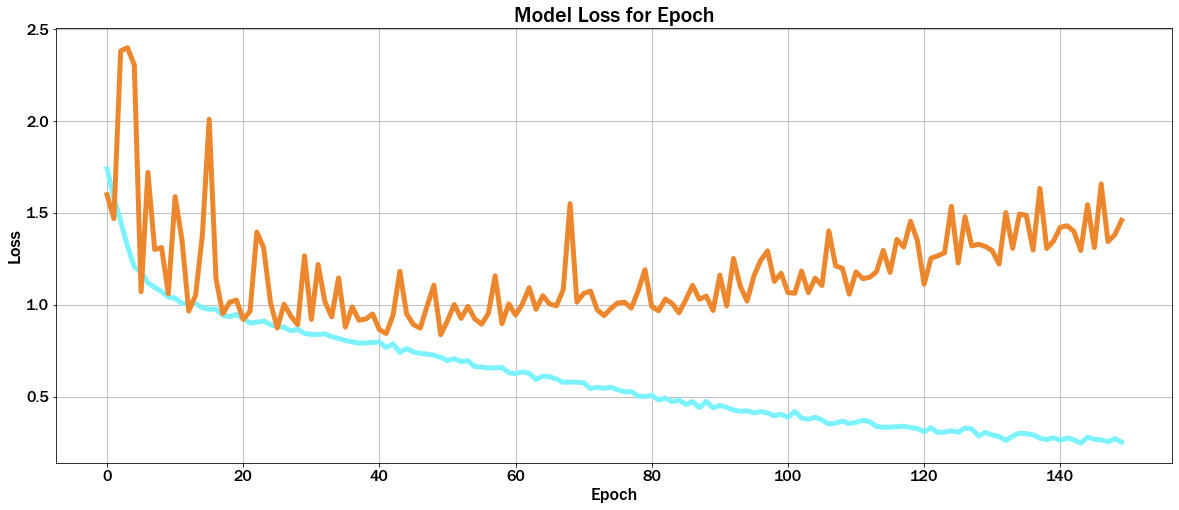

In [29]:
ax = sns.lineplot(x=np.arange(0, args["epoch_num"], 1), y = train_losses, lw=5, color="#7df2ff")
ax.figure.set_size_inches(20, 8)
sns.lineplot(x=np.arange(0, args["epoch_num"], 1), y = test_losses, lw=5, color="#ed872d")
plt.grid(True)
ax.set_title("Model Loss for Epoch", font=font, fontsize=22)
ax.set_xlabel("Epoch", font=font, fontsize=18)
ax.set_ylabel("Loss", font=font, fontsize=18)
plt.xticks(font=font, fontsize=16)
plt.yticks(font=font, fontsize=16)
plt.show()

<div style="font-family:'Nunito', sans-serif; font-size:18px">In final epochs, it got a little overfitted, but have a fine generalization. But let's see more detailed the label prediction to find what else could be the increase of loss in validating.</div>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Classification Report:</b> a metrics report for each class (label) to see which the model identified better.</div>

In [30]:
# Real Test Values 
validation_images = test_set.images.to(args["device"]) 
validation_labels = test_set.labels

# Predict
y_pred = np.array([np.argmax(net(image.unsqueeze(0)).cpu().detach().numpy()) for image in validation_images])

# Transform the numeric label back to string
validation_labels = list(map(lambda x: unique_labels[x], validation_labels))
y_pred = list(map(lambda x: unique_labels[x], y_pred))

In [31]:
# Transform the report into a DataFrame
report = classification_report(validation_labels, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T
report_df.index = [i.title() for i in report_df.index]
report_df.columns = [j.title() for j in report_df.columns]

In [32]:
col_map = sns.color_palette("coolwarm_r", as_cmap=True)
report_df.style.background_gradient(subset="Precision", cmap=col_map)\
               .background_gradient(subset="Recall", cmap=col_map)\
               .background_gradient(subset="F1-Score", cmap=col_map)\
               .set_properties(**{"font-size": "11pt"})

<div style="font-family:'Nunito', sans-serif; font-size:18px">The poor prediction results on labels <b>Frost, Glaze and Snow</b> probably means that the model have a difficult to differentiate them in reason of their similarity. <b>Fogsmog</b> and <b> Sandstorm</b> have a excellent classification score because of remarkable differences of these weathers from others.</div>

# **Validating with sample**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Validating:</b> randomly selected 2 images for each label and predicted. To better visualization, it plots the image with the legend of its true label and the predicted label.</div>

In [33]:
sample_labels = unique_labels * 2
sample_labels.sort()

sample_images = np.array([])
np.random.seed(404)
for label in sample_labels:
    sample = df.query("label == '%s'" % label).sample(1)
    sample_images = np.append(sample_images, sample["image"].values)

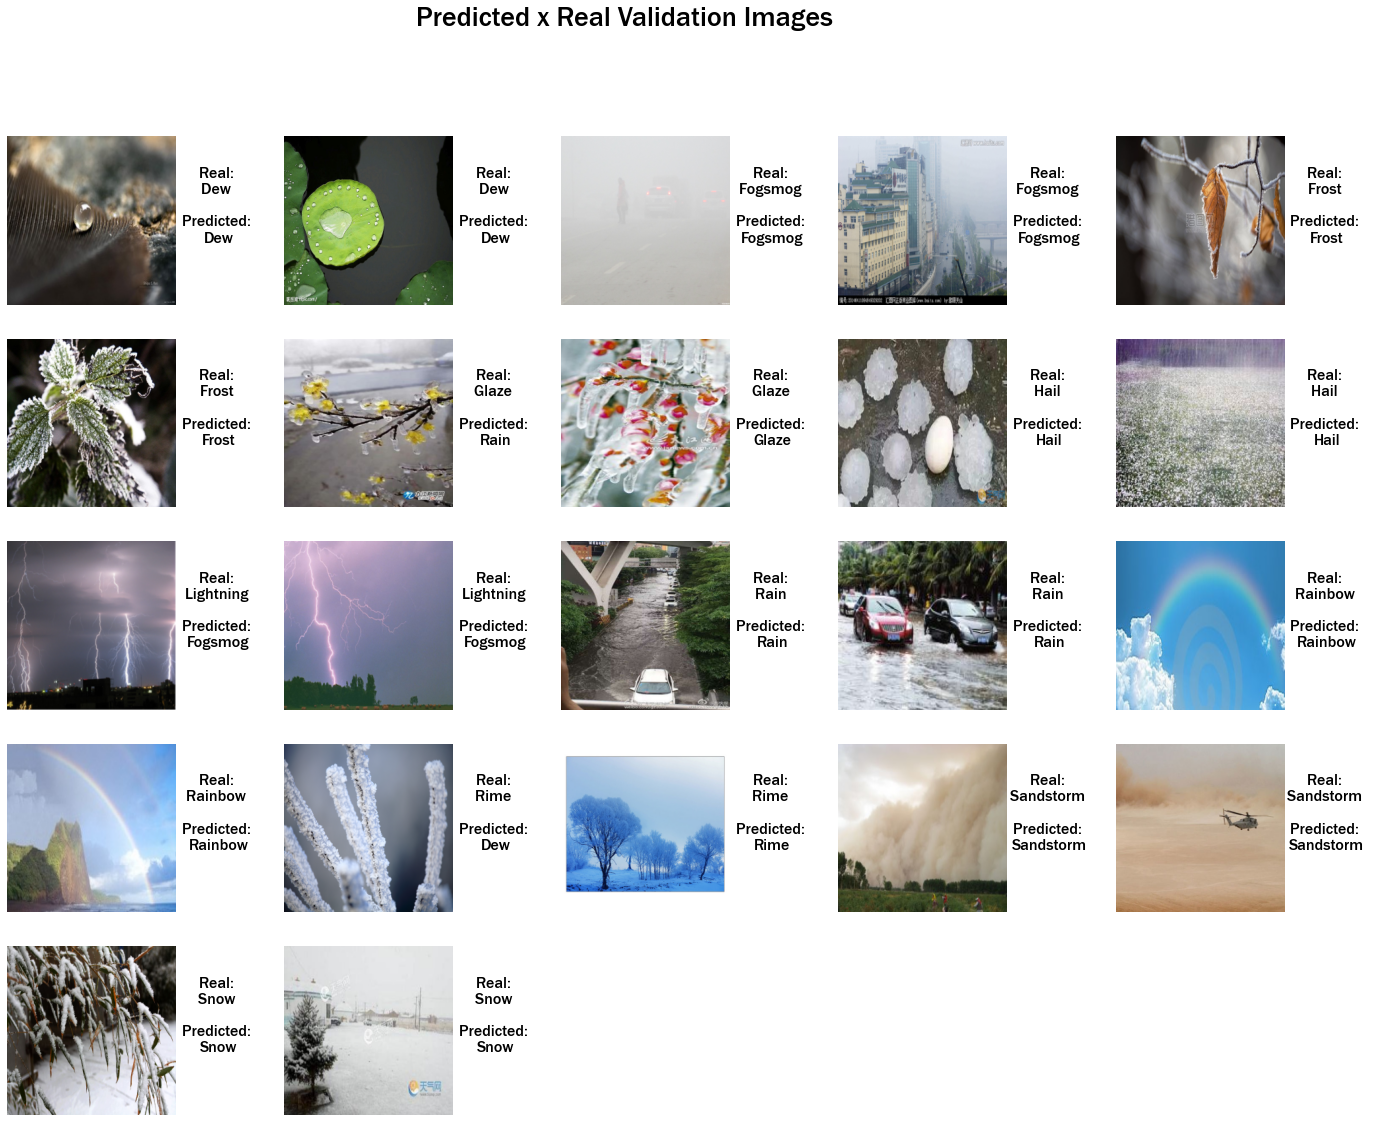

In [34]:
plt.figure(figsize=(24, 18))

for j, img in enumerate(sample_images):
    ax = plt.subplot(5, 5, j + 1)
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_AREA)
    
    plt.imshow(image)
    plt.axis("off")
    
    image = np.array(image, dtype=np.float32)
    image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(args["device"])
    index = np.argmax(net(image_tensor).cpu().detach().numpy())
    y_pred = unique_labels[index]
    
    text = "Real: \n%s \n\nPredicted: \n%s" % (sample_labels[j].title(), y_pred.title())
    ax.text(s=text, y=160, x=320, fontsize=16, font=font, ha="center")

plt.suptitle("Predicted x Real Validation Images", font=font, fontsize=28)
plt.show()

<div style="font-family:'Nunito', sans-serif; font-size:18px">As verified before, the model mistakes <b>Frost</b> with <b>Hail and Rime</b> because of their similarities. The remainder labels generalized very well.</div>

# **Predict new Data**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px"><b style="background-color:#b3f7ff; font-size:20px; padding:5px">Predict Real Images:</b> in order to predict new images, I created a class where the init input is the net that will be evaluated while the function takes the url and the real label.</div>

In [35]:
class PredictImage:
    def __init__(self, net):
        self.net = net
        
    def predict_image(self, image): 
        img = np.array(image, dtype=np.float32)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).to(args["device"])
        index = np.argmax(self.net(img_tensor).cpu().detach().numpy())
        y_pred = unique_labels[index]
        self.show_image(image, y_pred)
        
    def predict_web_image(self, url, true_label):
        """Predict from a URL with jpg extension"""
        img_data = requests.get(url).content
        self.filepath = true_label + ".jpg"
        self.true_label = true_label
        
        with open(self.filepath, 'wb') as f:
            f.write(img_data)
        
        image = self.read_image(web=True)
        return self.predict_image(image)
    
    def read_image(self, path=None, web=False):
        if web:
            img = cv2.imread(self.filepath)
        else:
            img = cv2.imread(path)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
        
        return img
        
    def show_image(self, image_arr, prediction):
        plt.figure(figsize=(16, 10))
        plt.imshow(image_arr)
        plt.axis("off")
        text = "Real: %s \n\nPredicted: %s" % (self.true_label.title(), prediction.title())
        plt.text(s=text, y = 130, x = 265, font=font, fontsize=22)
        plt.show()

In [36]:
predict = PredictImage(net)

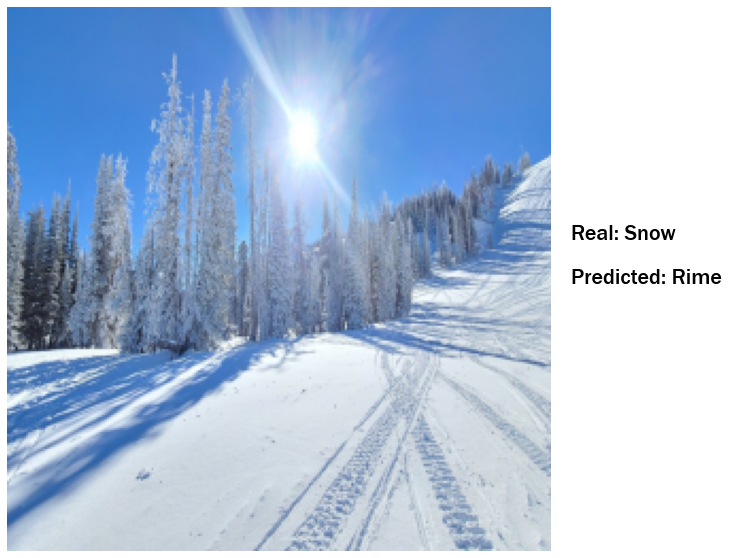

In [37]:
predict.predict_web_image("https://ewscripps.brightspotcdn.com/dims4/default/c89b5ad/2147483647/strip/true/crop/1920x1080+0+1/resize/1280x720!/quality/90/?url=http%3A%2F%2Fewscripps-brightspot.s3.amazonaws.com%2Fe9%2F03%2Faa83688a4490b78de1796035d3b8%2F1920-61ecb0e249d2c-20220122-125544.jpg", "Snow")

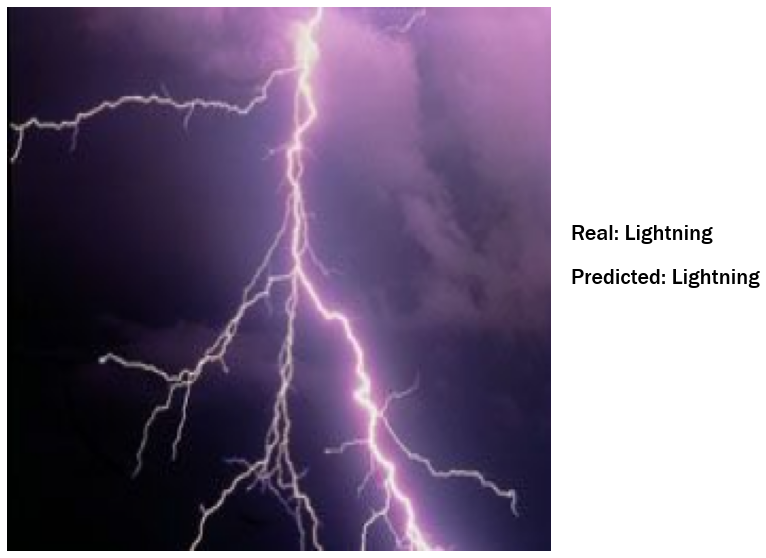

In [38]:
predict.predict_web_image("https://cdn.britannica.com/13/24313-004-0861FD8C/lightning-discharge-branches-channel.jpg?w=400&h=300&c=crop", 
                          "Lightning")

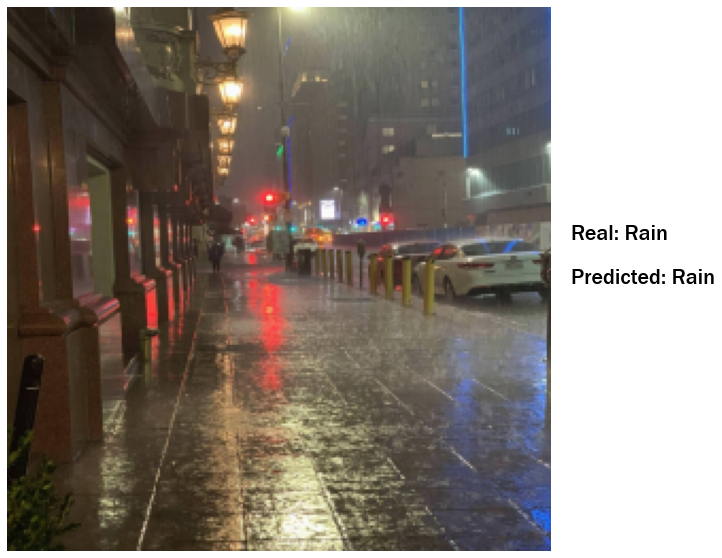

In [39]:
predict.predict_web_image("https://external-preview.redd.it/xYbDQzlzjADDTykFyxbEI83BXkAh8Qu01oets3OChqI.jpg?width=1200&height=628.272251309&auto=webp&s=272dcce8515eb6c4d1773b2d80844dea47eef589", 
                          "Rain")

# **Conclusion**
<hr style="background-color:#00dbf3; color:#00dbf3; height:10px"></hr>

<div style="font-family:'Nunito', sans-serif; font-size:18px">The model mistakes <b>Frost</b> with <b>Hail and Rime</b> in evaluation, that increases the loss in validation during training.</div>
<div style="font-family:'Nunito', sans-serif; font-size:18px">The model has an <b>accuracy of 70%</b> in new images.</div>

<div style="font-family:'Nunito', sans-serif; font-size:18px">I hope you liked the notebook! Leave a comment if you have a constructive criticism!.</div>